# Developing User Base Recommender System for a Movie Platform
# Business Problem

Developing a user-based recommender system for a movie streaming platform or an online movie rental service. The goal is to provide personalized movie recommendations to users based on their viewing history and preferences, as well as the preferences of similar users.

# Business Understanding:
The movie streaming or rental platform has a vast collection of movies, and users often find it challenging to discover new movies that align with their interests. By implementing a user-based recommender system, the platform can enhance the user experience by suggesting relevant and engaging movies tailored to each user's tastes. This is aimed at increasing user satisfaction, retention, and potentially higher revenue through improved engagement and movie consumption.

# Data Understanding
The dataset contains movie ratings provided by users. It includes information such as user IDs, movie IDs, ratings, and timestamps. The dataset is typically split into multiple files, including ratings.csv, movies.csv, links.csv, and tags.csv, each providing different aspects of movie-related data.

## Model: User-based Recommender System
A user-based recommender system is a type of collaborative filtering technique that makes recommendations based on similarities between users. The steps to be followed in the process are as follows:

1. Data Preparation: This wil entail extracting relevant information from the datasets which will include; userIds, movieIds, ratings, and movie genres. Next preprocessing the data by handling missing values, encoding categorical variables, and ensuring data consistency.

2. User Similarity Calculation: This will involve calculating the pairwise similarity between users based on their rating patterns. Similarity measures to be calculated include; cosine similarity and Pearson correlation coefficient.

3. Neighborhood Formation: This will entail identifying, for each user, a set of similar users (neighbors) based on the calculated similarities. The neighborhood size will be determined by setting a threshold or selecting the top-k most similar users.

4. Prediction and Recommendation:  This will involve predicting,  for a given user, the rating for an unseen movie by aggregating the ratings of that movie from the user's neighbors. Aggregation techniques to be adopted include; weighted average, mean, or median. Out of this, recommendation will be done for the movies with the highest predicted ratings to the user.

5. Evaluation and Refinement: The performance of the recommender system will be evaluate the  using metricsthat will include mean absolute error (MAE), root mean squared error (RMSE), or precision and recall. Iteratively, the model will be refined by adjusting parameters, similarity measures, or incorporating additional features (e.g., movie genres, tags) to improve recommendations.

In [4]:
# Importing the relevant libraries
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns

#loading the datasets
df_links= pd.read_csv('links.csv')
df_movies= pd.read_csv('movies.csv')
df_tags= pd.read_csv('tags.csv')
df_ratings= pd.read_csv('ratings.csv')

In [5]:
df_links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [6]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
df_tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [8]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [9]:
#get the dataset information
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


Organizing key statistics about the rating dataset 

In [10]:
#checking the number of users
num_users = df_ratings['userId'].nunique()
print('The rating dataset has', num_users, 'unique users')
#checking the number of movies
num_movies = df_ratings['movieId'].nunique()
print('The rating dataset has', num_movies, 'unique movies')
#number of ratings 
num_ratings = df_ratings['rating'].nunique()
print('The rating dataset has', num_ratings, 'unique ratings')
#list of unique ratings
print('The rating dataset has', sorted(df_ratings['rating'].unique()))

The rating dataset has 610 unique users
The rating dataset has 9724 unique movies
The rating dataset has 10 unique ratings
The rating dataset has [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


In [11]:
#merge ratings and movies dataset
df= pd.merge(df_ratings, df_movies, on= 'movieId', how='inner')
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


# Explorative Data Analysis


First to ensure that the memory is management to reduce chances of crashing.  movies with 100 ratings will be filter and retained for analysis. This will be achieved by grouping movies by title, count the number of ratings retaining only those with ratings greater than 100.

In [12]:
#Group by movie title and aggregate ratings data
agg_ratings = df.groupby('title').agg(mean_rating=('rating', 'mean'), 
                                   num_of_ratings = ('rating', 'count')).reset_index()
# Display the aggregated ratings data
print(agg_ratings)

                                          title  mean_rating  num_of_ratings
0                                    '71 (2014)     4.000000               1
1       'Hellboy': The Seeds of Creation (2004)     4.000000               1
2                        'Round Midnight (1986)     3.500000               2
3                           'Salem's Lot (2004)     5.000000               1
4                     'Til There Was You (1997)     4.000000               2
...                                         ...          ...             ...
9714                            eXistenZ (1999)     3.863636              22
9715                                 xXx (2002)     2.770833              24
9716             xXx: State of the Union (2005)     2.000000               5
9717                      ¡Three Amigos! (1986)     3.134615              26
9718  À nous la liberté (Freedom for Us) (1931)     1.000000               1

[9719 rows x 3 columns]


In [13]:
# Filter movies with over 100 ratings
agg_ratings_filtered = agg_ratings[agg_ratings['num_of_ratings'] > 100]

# Display the filtered DataFrame
agg_ratings_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134 entries, 74 to 9615
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           134 non-null    object 
 1   mean_rating     134 non-null    float64
 2   num_of_ratings  134 non-null    int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 4.2+ KB


In [14]:
#checking the most popular movies and their ratings
# by sorting the df by number of ratings in descending order
most_popular_movies = agg_ratings_filtered.sort_values(by='num_of_ratings', ascending=False)

# Display the most popular movies and their ratings
most_popular_movies.head()

,title,mean_rating,num_of_ratings
3158,Forrest Gump (1994),4.164134,329
7593,"Shawshank Redemption, The (1994)",4.429022,317
6865,Pulp Fiction (1994),4.197068,307
7680,"Silence of the Lambs, The (1991)",4.161290,279
5512,"Matrix, The (1999)",4.192446,278


Most popular movies had an mean rating of around 4 with the highest number of ratings per moie being 329.

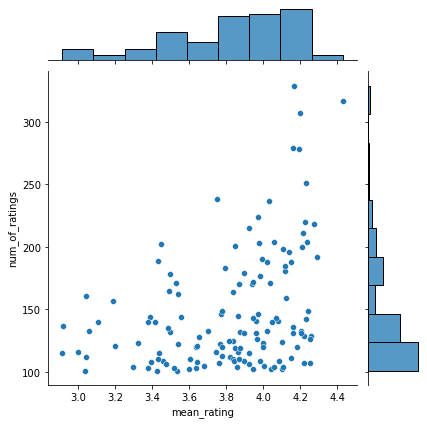

In [15]:
#using jointplot to check the correlation 
# between the average rating and number of ratings
sns.jointplot(x='mean_rating', y='num_of_ratings', data=agg_ratings_filtered, kind='scatter')


The upward trend in the scatter plot illustrate that popular movies have a higher rating

We need to retain only the 134 movies that had more than 100 ratings. This will be achieved by joining the movie with the user-rating level dataframe.

In [16]:
# Performing a join operation between the movie DataFrame and the aggregated DataFrame containing the count of ratings for each movie
df_filtered = pd.merge(df, agg_ratings_filtered[['title']],how='inner', on='title')

# Display the first few rows of the filtered DataFrame
df_filtered.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 19788 entries, 0 to 19787
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     19788 non-null  int64  
 1   movieId    19788 non-null  int64  
 2   rating     19788 non-null  float64
 3   timestamp  19788 non-null  int64  
 4   title      19788 non-null  object 
 5   genres     19788 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 1.1+ MB


Calculating the number of movies with over 100 ratings and users who rated them

In [17]:
# Number of users
print('The ratings dataset has', df_filtered['userId'].nunique(), 'unique users')

# Number of movies
print('The ratings dataset has', df_filtered['movieId'].nunique(), 'unique movies')

# Number of ratings
print('The ratings dataset has', df_filtered['rating'].nunique(), 'unique ratings')

# List of unique ratings
print('The unique ratings are', df_filtered['rating'].nunique())

The ratings dataset has 597 unique users
The ratings dataset has 134 unique movies
The ratings dataset has 10 unique ratings
The unique ratings are 10


## Developing User-Movie Matrix

We'll convert the dataset into a matrix structure where the rows represent users and the columns represent movies. Each cell in the matrix indicates the user's rating for a specific movie, with 'NaN' denoting missing ratings.

In [18]:
# Create user-item matrix
movie_matrix = df_filtered.pivot_table(index='userId', columns='title', values='rating')
movie_matrix.head()

title,2001: A Space Odyssey (1968),Ace Ventura: Pet Detective (1994),Aladdin (1992),Alien (1979),Aliens (1986),"Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",American Beauty (1999),American History X (1998),American Pie (1999),Apocalypse Now (1979),...,True Lies (1994),"Truman Show, The (1998)",Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Twister (1996),Up (2009),"Usual Suspects, The (1995)",WALL·E (2008),Waterworld (1995),Willy Wonka & the Chocolate Factory (1971),X-Men (2000)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,4.0,NaN,NaN,5.0,5.0,NaN,4.0,...,NaN,NaN,NaN,3.0,NaN,5.0,NaN,NaN,5.0,5.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,4.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,...,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN
5,NaN,3.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN


## Normalizing the Data

Due to variations in rating tendencies among individuals, we employ normalization by calculating the average rating provided by each user.

Following normalization, movies rated below a user's average rating are assigned a negative value, while movies rated above a user's average rating are assigned a positive value. 

In [19]:
# Normalizing user-item matrix
movie_matrix_norm = movie_matrix.subtract(movie_matrix.mean(axis=1), axis = 'rows')
movie_matrix_norm.head()

title,2001: A Space Odyssey (1968),Ace Ventura: Pet Detective (1994),Aladdin (1992),Alien (1979),Aliens (1986),"Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",American Beauty (1999),American History X (1998),American Pie (1999),Apocalypse Now (1979),...,True Lies (1994),"Truman Show, The (1998)",Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Twister (1996),Up (2009),"Usual Suspects, The (1995)",WALL·E (2008),Waterworld (1995),Willy Wonka & the Chocolate Factory (1971),X-Men (2000)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,-0.392857,NaN,NaN,0.607143,0.607143,NaN,-0.392857,...,NaN,NaN,NaN,-1.392857,NaN,0.607143,NaN,NaN,0.607143,0.607143
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,0.617647,NaN,NaN,NaN,1.617647,NaN,NaN,NaN,...,NaN,NaN,-1.382353,NaN,NaN,NaN,NaN,NaN,0.617647,NaN
5,NaN,-0.461538,0.538462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.461538,NaN,NaN,NaN,NaN,0.538462,NaN,NaN,NaN,NaN


## Similar User Identification

This anlysis will compute Pearson correlation and cosine similarity. 
### User Similarity using Pearson Correlation

In [20]:
# User similarity matrix using Pearson correlation
user_similarity_corr = movie_matrix_norm.T.corr()
user_similarity_corr.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,NaN,NaN,0.391797,0.180151,-0.439941,-0.029894,0.464277,1.0,-0.037987,...,0.091574,0.254514,0.101482,-0.500000,0.780020,0.303854,-0.012077,0.242309,-0.175412,0.071553
2,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,...,-0.583333,NaN,-1.000000,NaN,NaN,0.583333,NaN,-0.229416,NaN,0.765641
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.391797,NaN,NaN,1.000000,-0.394823,0.421927,0.704669,0.055442,NaN,0.360399,...,-0.239325,0.562500,0.162301,-0.158114,0.905134,0.021898,-0.020659,-0.286872,NaN,-0.050868
5,0.180151,NaN,NaN,-0.394823,1.000000,-0.006888,0.328889,0.030168,NaN,-0.777714,...,0.000000,0.231642,0.131108,0.068621,-0.245026,0.377341,0.228218,0.263139,0.384111,0.040582


### User Similarity using Cosine technique
Because cosine_similarity cannot handle missing values, it's necessary to fill these gaps with zeros before performing the calculation. 

In [21]:
# User similarity matrix using cosine similarity
user_similarity_cos = cosine_similarity(movie_matrix_norm.fillna(0))
user_similarity_cos

array([[ 1.        ,  0.        ,  0.        , ...,  0.14893867,
        -0.06003146,  0.04528224],
       [ 0.        ,  1.        ,  0.        , ..., -0.04485403,
        -0.25197632,  0.18886414],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.14893867, -0.04485403,  0.        , ...,  1.        ,
         0.14734568,  0.07931015],
       [-0.06003146, -0.25197632,  0.        , ...,  0.14734568,
         1.        , -0.14276787],
       [ 0.04528224,  0.18886414,  0.        , ...,  0.07931015,
        -0.14276787,  1.        ]])

Next, we select a specific user ID, removes the user ID from the user similarity matrix, which will exclude it from consideration in similarity calculations with other users. we then display the updated user similarity matrix, showing the remaining users and their similarity scores.

In [22]:
# Pick a user ID
picked_userid = 1

# Remove picked user ID from the candidate list
user_similarity_corr.drop(index=picked_userid, inplace=True)

# Take a look at the data
user_similarity_corr.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
2,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,...,-0.583333,NaN,-1.000000,NaN,NaN,0.583333,NaN,-0.229416,NaN,0.765641
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.391797,NaN,NaN,1.000000,-0.394823,0.421927,0.704669,0.055442,NaN,0.360399,...,-0.239325,0.562500,0.162301,-0.158114,0.905134,0.021898,-0.020659,-0.286872,NaN,-0.050868
5,0.180151,NaN,NaN,-0.394823,1.000000,-0.006888,0.328889,0.030168,NaN,-0.777714,...,0.000000,0.231642,0.131108,0.068621,-0.245026,0.377341,0.228218,0.263139,0.384111,0.040582
6,-0.439941,NaN,NaN,0.421927,-0.006888,1.000000,0.000000,-0.127385,NaN,0.957427,...,-0.292770,-0.030599,-0.123983,-0.176327,0.063861,-0.468008,0.541386,-0.337129,0.158255,-0.030567


### Identifying Most Similar Users

In the user similarity matrix, the values span from -1 to 1, where -1 indicates opposite movie preferences and 1 indicates similar movie preferences.

we aim to select the top 10 most akin users for user ID 1, thus Setting n = 10 

User-based collaborative filtering generates recommendations based on users with comparable preferences, hence we establish a positive threshold. In this scenario, the user_similarity_threshold is set to 0.3, indicating that a user must possess a Pearson correlation coefficient of at least 0.3 to be considered a similar user.

Following the specification of the number of similar users and the similarity threshold, we arrange the user similarity values from highest to lowest and then display the IDs of the most similar users along with their Pearson correlation values.

In [23]:
# Number of similar users
n = 10

# User similarity threashold
user_similarity_threshold = 0.3

# Get top n similar users
similar_users = user_similarity_corr[user_similarity_corr[picked_userid]>user_similarity_threshold][picked_userid].sort_values(ascending=False)[:n]

# Print out top n similar users
print(f'The similar users for user {picked_userid} are', similar_users)

The similar users for user 1 are userId
502    1.000000
9      1.000000
598    1.000000
550    1.000000
108    1.000000
401    0.942809
511    0.925820
366    0.872872
595    0.866025
154    0.866025
Name: 1, dtype: float64


### Refining the Item Selection

Under here we exclude the movies already viewed by the selected user (user ID 1 in this instance).Then retain only the movies watched by similar users.

To eliminate the movies watched by the target user, we isolate the row corresponding to userId=1 in the user-item matrix and exclude the items with missing values.

In [24]:
# Movies watched by the target user 
picked_userid_watched = movie_matrix_norm[movie_matrix_norm.index == picked_userid].dropna(axis=1, how='all')
picked_userid_watched

title,Alien (1979),American Beauty (1999),American History X (1998),Apocalypse Now (1979),Back to the Future (1985),Batman (1989),"Big Lebowski, The (1998)",Braveheart (1995),Clear and Present Danger (1994),Clerks (1994),...,Star Wars: Episode IV - A New Hope (1977),Star Wars: Episode V - The Empire Strikes Back (1980),Star Wars: Episode VI - Return of the Jedi (1983),Stargate (1994),"Terminator, The (1984)",Toy Story (1995),Twister (1996),"Usual Suspects, The (1995)",Willy Wonka & the Chocolate Factory (1971),X-Men (2000)
userId,,,,,,,,,,,,,,,,,,,,,
1,-0.392857,0.607143,0.607143,-0.392857,0.607143,-0.392857,0.607143,-0.392857,-0.392857,-1.392857,...,0.607143,0.607143,0.607143,-1.392857,0.607143,-0.392857,-1.392857,0.607143,0.607143,0.607143


To retain only the movies watched by similar users, we retain the user IDs in the top 10 similar user lists and eliminate the movies with all missing values. A movie with all missing values implies that none of the similar users have viewed the movie.

In [25]:
# Movies that similar users watched. Remove movies that none of the similar users have watched
similar_user_movies = movie_matrix_norm[movie_matrix_norm.index.isin(similar_users.index)].dropna(axis=1, how='all')
similar_user_movies

title,Aladdin (1992),Alien (1979),"Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",Back to the Future (1985),Batman Begins (2005),"Beautiful Mind, A (2001)",Beauty and the Beast (1991),Blade Runner (1982),"Bourne Identity, The (2002)",Braveheart (1995),...,Shrek (2001),"Silence of the Lambs, The (1991)",Spider-Man (2002),Star Wars: Episode I - The Phantom Menace (1999),Terminator 2: Judgment Day (1991),Titanic (1997),Toy Story (1995),Up (2009),"Usual Suspects, The (1995)",WALL·E (2008)
userId,,,,,,,,,,,,,,,,,,,,,
9,NaN,NaN,NaN,0.333333,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108,NaN,NaN,0.466667,0.466667,NaN,0.466667,NaN,0.466667,NaN,NaN,...,NaN,NaN,0.466667,NaN,NaN,-0.533333,NaN,NaN,NaN,NaN
154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.214286,NaN,NaN
366,NaN,NaN,NaN,NaN,-0.205882,NaN,NaN,NaN,NaN,-0.205882,...,NaN,NaN,NaN,NaN,-0.205882,NaN,NaN,NaN,NaN,NaN
401,-0.382353,NaN,NaN,NaN,NaN,NaN,-0.382353,NaN,NaN,NaN,...,0.117647,NaN,NaN,NaN,NaN,NaN,0.117647,0.617647,NaN,0.617647
502,NaN,-0.375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
511,NaN,NaN,-0.653846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-1.153846,-0.653846,NaN,NaN,NaN,-0.153846,NaN,NaN
550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.277778,0.222222,NaN,-0.277778
595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.333333,NaN,NaN,NaN,NaN,0.666667,NaN


We will exclude the movies that user ID 1 has watched from the list of movies watched by similar users. Using the parameter errors='ignore' ensures that columns are dropped if they exist without raising an error message.

In [26]:
 #Exclusing watched movie from the movie list
similar_user_movies.drop(picked_userid_watched.columns,axis=1, inplace=True, errors='ignore')

# checking the new data
similar_user_movies

title,Aladdin (1992),"Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",Batman Begins (2005),"Beautiful Mind, A (2001)",Beauty and the Beast (1991),Blade Runner (1982),"Bourne Identity, The (2002)","Breakfast Club, The (1985)",Catch Me If You Can (2002),"Dark Knight, The (2008)",...,"Monsters, Inc. (2001)",Ocean's Eleven (2001),Pirates of the Caribbean: The Curse of the Black Pearl (2003),"Shawshank Redemption, The (1994)",Shrek (2001),Spider-Man (2002),Terminator 2: Judgment Day (1991),Titanic (1997),Up (2009),WALL·E (2008)
userId,,,,,,,,,,,,,,,,,,,,,
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108,NaN,0.466667,NaN,0.466667,NaN,0.466667,NaN,-0.533333,0.466667,NaN,...,NaN,NaN,NaN,NaN,NaN,0.466667,NaN,-0.533333,NaN,NaN
154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.214286,NaN
366,NaN,NaN,-0.205882,NaN,NaN,NaN,NaN,NaN,NaN,-0.205882,...,NaN,NaN,-0.205882,NaN,NaN,NaN,-0.205882,NaN,NaN,NaN
401,-0.382353,NaN,NaN,NaN,-0.382353,NaN,NaN,NaN,NaN,NaN,...,0.117647,NaN,0.117647,NaN,0.117647,NaN,NaN,NaN,0.617647,0.617647
502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.125000,NaN,NaN,NaN,NaN,NaN,NaN
511,NaN,-0.653846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.346154,NaN,-1.153846,NaN,NaN,-0.153846,NaN
550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.277778,-0.277778,...,NaN,NaN,NaN,0.222222,NaN,NaN,NaN,NaN,0.222222,-0.277778
595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Items Recommendation


We will determine which movies to recommend to the target user by calculating the weighted average of user similarity scores and movie ratings. The ratings for each movie are weighted by the similarity scores, giving higher weights to users with greater similarity.

The next code iterates through the items and users to calculate the item score, ranks the scores from high to low, and selects the top 10 movies to recommend to user ID 1.

In [27]:
# Initialize an empty dictionary to store item scores for recommendation
item_score = {}

# Iterating through the items available for recommendation
for i in similar_user_movies.columns:
  # Obtain the movie i ratings 
  movie_rating = similar_user_movies[i]
  # Create a variable to store the score
  total = 0
  # Create a variable to store the number of scores
  count = 0
  # Iterating through similar users
  for u in similar_users.index:
    # If the movie has rating
    if pd.isna(movie_rating[u]) == False:
      # Score is the sum of user similarity score multiply by the movie rating
      score = similar_users[u] * movie_rating[u]
      # Add the score to the total score for the movie so far
      total += score
      # Add 1 to the count
      count +=1
  # Get the average score for the item
  item_score[i] = total / count

# Convert dictionary to pandas dataframe
item_score = pd.DataFrame(item_score.items(), columns=['movie', 'movie_score'])

# Sort the movies by score
ranked_item_score = item_score.sort_values(by='movie_score', ascending=False)

# Select top m movies
m = 10
ranked_item_score.head(m)

,movie,movie_score
16,Harry Potter and the Chamber of Secrets (2002),1.888889
13,Eternal Sunshine of the Spotless Mind (2004),1.888889
6,"Bourne Identity, The (2002)",0.888889
29,Ocean's Eleven (2001),0.888889
18,Inception (2010),0.587491
3,"Beautiful Mind, A (2001)",0.466667
5,Blade Runner (1982),0.466667
12,Donnie Darko (2001),0.466667
10,"Departed, The (2006)",0.256727
31,"Shawshank Redemption, The (1994)",0.222566


### Scores Prediction

To predict user's ratings we add the user's average movie rating score back to the movie score

In [28]:
# Average rating for the picked user
avg_rating = movie_matrix[movie_matrix.index == picked_userid].T.mean()[picked_userid]

# Print the average movie rating for user 1
print(f'The average movie rating for user {picked_userid} is {avg_rating:.2f}')

The average movie rating for user 1 is 4.39


In [29]:
# Calcuate the predicted rating
ranked_item_score['predicted_rating'] = ranked_item_score['movie_score'] + avg_rating

# Clip the predicted ratings to the valid range (0.5 to 5.0)
ranked_item_score['predicted_rating'] = ranked_item_score['predicted_rating'].clip(0.5, 5.0)

# check the data
ranked_item_score.head(m)

,movie,movie_score,predicted_rating
16,Harry Potter and the Chamber of Secrets (2002),1.888889,5.000000
13,Eternal Sunshine of the Spotless Mind (2004),1.888889,5.000000
6,"Bourne Identity, The (2002)",0.888889,5.000000
29,Ocean's Eleven (2001),0.888889,5.000000
18,Inception (2010),0.587491,4.980348
3,"Beautiful Mind, A (2001)",0.466667,4.859524
5,Blade Runner (1982),0.466667,4.859524
12,Donnie Darko (2001),0.466667,4.859524
10,"Departed, The (2006)",0.256727,4.649584
31,"Shawshank Redemption, The (1994)",0.222566,4.615423


 The top 10 recommended movies all have predicted ratings greater than 4.5.

In [37]:
# Average rating for the picked user
avg_rating = movie_matrix[movie_matrix.index == picked_userid].T.mean()[picked_userid]

# Calculate the predicted rating
ranked_item_score['predicted_rating'] = ranked_item_score['movie_score'] + avg_rating

#  Clip the predicted ratings to the valid range (0.5 to 5.0)
ranked_item_score['predicted_rating'] = ranked_item_score['predicted_rating'].clip(0.5, 5.0)

# Display the predicted ratings
ranked_item_score.head(10)

,movie,movie_score,predicted_rating
16,Harry Potter and the Chamber of Secrets (2002),1.888889,5.000000
13,Eternal Sunshine of the Spotless Mind (2004),1.888889,5.000000
6,"Bourne Identity, The (2002)",0.888889,5.000000
29,Ocean's Eleven (2001),0.888889,5.000000
18,Inception (2010),0.587491,4.980348
3,"Beautiful Mind, A (2001)",0.466667,4.859524
5,Blade Runner (1982),0.466667,4.859524
12,Donnie Darko (2001),0.466667,4.859524
10,"Departed, The (2006)",0.256727,4.649584
31,"Shawshank Redemption, The (1994)",0.222566,4.615423
